In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import wandb
import tensorflow as tf
import os
import chardet
import pandas as pd
from transformers import TrOCRProcessor

AUTOTUNE = tf.data.AUTOTUNE

wandb.init(
    project="Newspaper-TrOCR_printed_text_small_v1.1",
    config={
        "batch_size": 16,
        "learning_rate": 5e-5,
        "weight_decay": 0,
        "num_epochs": 6,
        "optimizer": "adam",
        "max_target_length": 106,
    },
)

config = wandb.config

wandb: Currently logged in as: salim-nassor-sn. Use `wandb login --relogin` to force relogin


In [2]:
def get_data(_path: str):
    try:
        # check if path is available
        if os.path.exists(_path):
            # check if path is a directory
            if os.path.isdir(_path):
                # check if directory is empty
                if len(os.listdir(_path)) == 0:
                    return "Directory is empty"
                else:
                    # check if directory contains files
                    files = [f for f in os.listdir(_path) if os.path.isfile(os.path.join(_path, f))]
                    if len(files) == 0:
                        return "Directory does not contain files"
                    else:
                        # check if files are images
                        image_files = [f for f in files if f.endswith(".jpg") or f.endswith(".jpeg") or f.endswith(".png")]
                        if len(image_files) == 0:
                            return "Directory does not contain image files"
                        else:
                            # check if files are text files
                            text_files = [f for f in files if f.endswith(".gt.txt")]
                            if len(text_files) == 0:
                                return "Directory does not contain text files"
                            else:
                                # check if number of image files is equal to number of text files
                                if len(image_files) != len(text_files):
                                    print(f"Number of image files: {len(image_files)}, Number of text files: {len(text_files)}")
                                    # return "Something went wrong. Number of image files is not equal to number of text files"
                                data = []
                                for _image in image_files:
                                    for text in text_files:
                                        # open text file and read content
                                        with open(os.path.join(_path, text), "rb") as f:
                                            text_content = f.read()
                                            text_content = text_content.decode("utf-8")
                                        if _image.split(".")[0] == text.split(".")[0]:
                                            data.append((_path +"/" + _image, text_content))
                                return data
            else:
                return "Path is not a directory"
        else:
            return "Path does not exist"
    except Exception as e:
        return e

In [3]:
# Get the data
def get_csv_data(_path):
    try:
        if os.path.isfile(_path):
            print('File exists')
            with open(_path, 'rb') as f:
                result = chardet.detect(f.read())
                _encoding = result['encoding']
                print(f'Encoding: {_encoding}')
            return pd.read_csv(_path, encoding="utf-8").dropna()
        else:
            print("Make sure the data is already prepared")
    except FileNotFoundError:
        print('File does not exist')

In [4]:
# training = get_data("Histrorical_News_Paper/TRAIN_DATA")

In [5]:
# create csv file for training data
# df = pd.DataFrame(training, columns=["image", "text"])
# df.to_csv("Histrorical_News_Paper/train.csv", index=False)
# this is already created

In [6]:
# # same with test data
# testing = get_data("Histrorical_News_Paper/TEST_DATA")
# # create csv file for testing data
# df = pd.DataFrame(testing, columns=["image", "text"])
# df.to_csv("Histrorical_News_Paper/test.csv", index=False, escapechar="\\")

In [7]:
training_df = get_csv_data("Histrorical_News_Paper/train.csv")
testing_df = get_csv_data("Histrorical_News_Paper/test.csv")

File exists
Encoding: utf-8
File exists
Encoding: utf-8


In [8]:
training_df.rename(columns={'image_path': 'file_name', 'label': 'text'}, inplace=True)
testing_df.rename(columns={'image_path': 'file_name', 'label': 'text'}, inplace=True)

In [9]:
training_df.head()

,image,text
0,Histrorical_News_Paper/TRAIN_DATA/0000000.bin.png,﻿gerne Watts och Doddrige hörde till
1,Histrorical_News_Paper/TRAIN_DATA/0000001.bin.png,"kiſka orden arti emot och nomos lag,"
2,Histrorical_News_Paper/TRAIN_DATA/0000002.bin.png,ſamt anſe lagen icke wara någon regel
3,Histrorical_News_Paper/TRAIN_DATA/0000003.bin.png,för deras tro. Deras ſtiftare war Joh.
4,Histrorical_News_Paper/TRAIN_DATA/0000004.bin.png,"Agricola, i början af Luthers lärjungar."


In [10]:
testing_df.head()

,image,text
0,Histrorical_News_Paper/TEST_DATA/0000000.bin.png,denna ſekt.
1,Histrorical_News_Paper/TEST_DATA/0000001.bin.png,﻿Antiomianer kallas ſå af Gre=
2,Histrorical_News_Paper/TEST_DATA/0000002.bin.png,De antaga ej goda gerningar ſåſom
3,Histrorical_News_Paper/TEST_DATA/0000003.bin.png,"nödwändiga medel till ſaligheten, och på="
4,Histrorical_News_Paper/TEST_DATA/0000004.bin.png,"ſtå, att de utwalde ingenting kunna"


In [11]:
training_df.reset_index(drop=True, inplace=True)
testing_df.reset_index(drop=True, inplace=True)

In [12]:
# figure out max_length for our labels
def max_length(_df):
    max_len = 0
    for i in range(len(_df)):
        text = _df["text"][i]
        print(text)
        if len(text) > max_len:
            max_len = len(text)
    return max_len

In [13]:
max_target_length = max_length(training_df)
config.max_target_length = max_target_length + 2

﻿gerne Watts och Doddrige hörde till
kiſka orden arti emot och nomos lag,
ſamt anſe lagen icke wara någon regel
för deras tro. Deras ſtiftare war Joh.
Agricola, i början af Luthers lärjungar.
göra, ſom ſtrider emot lagar och miß=
hagar Gud. Luther med flere har
ſkrifwit emot dem.
﻿Papiſterne hafwa fått ſin be=
barhet i andliga fall, och förſtått att
ſlag i den lyſande werlden.
﻿Grekiſka eller Ryſka Kyrkan
år gammal, och liknar i det närmaſte den
Romerſka. Den tror likwål ej på Påf=
wens ofelbarhet. Den ſkiljer ſig från
andra religionsbekännelſer deruti, att den
1) förkaſtor bilder i ſina tempel, 2) i
läran om konſubſtantiationen eller Chri=
och 3) werkſtäller dop genom hela
kroppens nedſänkande i wattnet.
i Lutherſka reformationens början protes=
terade emot Kejſar CarlV:s d ſ:it och
Reformerta. J Frankrike kallades de
Hugonotter, i Holland Flyktingar
i anledning af det beſkydo, ſom de ſok=
﻿te der, efter Nantiſka Ediktets äterkal=
lande 1685; i Skottland heta de Pres=
byterianer, och 

In [14]:
class CustomDataset(Dataset):
    def __init__(self, _df, _processor, _max_target_length = max_target_length + 2):
        self.df = _df
        self.processor = _processor
        self.max_target_length = _max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df['image'][idx]
        text = self.df['text'][idx]
        img = Image.open(img_path).convert('RGB')
        pixel_values = self.processor(img, return_tensors="pt").pixel_values
        labels = self.processor.tokenizer(text, padding="max_length", max_length = self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        _encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return _encoding

In [15]:
#  Let's try the small model only
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-printed", use_fast=False)
train_dataset = CustomDataset(training_df, processor)
eval_dataset = CustomDataset(testing_df, processor)

In [16]:
print(f"Train dataset: {len(train_dataset)}")
print(f"Eval dataset: {len(eval_dataset)}")

Train dataset: 6742
Eval dataset: 1651


In [17]:
encoding = train_dataset[0]
for k,v in encoding.items():
    print(f"{k}: {v.shape}")

pixel_values: torch.Size([3, 384, 384])
labels: torch.Size([109])


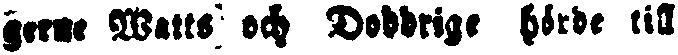

In [18]:
image = Image.open(training_df['image'][0]).convert('RGB')
image

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=config.batch_size)

In [20]:
from transformers import VisionEncoderDecoderModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# try the small model only
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-stage1")
model.to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [21]:
 # set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = max_target_length + 2
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [22]:
from datasets import load_metric

cer_metric = load_metric("cer", trust_remote_code=True)

C:\Users\salim\AppData\Local\Temp\ipykernel_30112\2544123437.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer", trust_remote_code=True)


In [23]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    _cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return _cer

In [24]:
from tqdm.notebook import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

best_cer = float('inf')  # start with a high CER

for epoch in range(config.num_epochs):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))

   # evaluate
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(eval_dataloader):
       # run batch generation
       outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer

   valid_cer /= len(eval_dataloader)
   print("Validation CER:", valid_cer)

   # save the best model
   if valid_cer < best_cer:
       print("New best model found!")
       best_cer = valid_cer
       model.save_pretrained("../custom_models/trocr_newspaper_printed/base/v1.0/vision_model/")
       processor.save_pretrained("./custom_models/trocr_newspaper_printed/base/v1.0/processor/")

wandb.finish()

  0%|          | 0/422 [00:00<?, ?it/s]

Loss after epoch 0: 2.1033323840789886


  0%|          | 0/104 [00:00<?, ?it/s]

C:\Users\salim\.conda\envs\ml\lib\site-packages\transformers\generation\utils.py:1364: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 109, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.15936411555991503
New best model found!


  0%|          | 0/422 [00:00<?, ?it/s]

Loss after epoch 1: 0.8589581136031174


  0%|          | 0/104 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 109, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.11405923599907296
New best model found!


  0%|          | 0/422 [00:00<?, ?it/s]

Loss after epoch 2: 0.7004054411186427


  0%|          | 0/104 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 109, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.10332216119012703
New best model found!


  0%|          | 0/422 [00:00<?, ?it/s]

Loss after epoch 3: 0.6262944145790209


  0%|          | 0/104 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 109, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.09711744446344767
New best model found!


  0%|          | 0/422 [00:00<?, ?it/s]

Loss after epoch 4: 0.5247159186415198


  0%|          | 0/104 [00:00<?, ?it/s]

Validation CER: 0.10816703480363092


  0%|          | 0/422 [00:00<?, ?it/s]

Loss after epoch 5: 0.4896174441511032


  0%|          | 0/104 [00:00<?, ?it/s]

Validation CER: 0.18327262651955809
